# Data Exploratory to Answer Question in task 1

In [26]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from pandas import Series
from matplotlib import pyplot
from statsmodels.tsa.seasonal import seasonal_decompose

import sys

In [27]:

#import custome modules
sys.path.append('../')

from scripts.get_missing_information import MissingInformation
from scripts.get_dataframe_information import DataFrameInformation
from scripts.ploting_utils import Plotters
from scripts.data_clean_handler import CleanData
from scripts import data_loader

from scripts.dvc_data_fetch import DataLoader

dvc_load = DataLoader()

cleaner = CleanData()
minfo = MissingInformation()
dinfo = DataFrameInformation()
pltu = Plotters(6,4)

In [28]:
# store_df = pd.read_csv('../data/cleaned/store.csv')
# train_df = pd.read_csv('../data/merged/train.csv')
# test_df = pd.read_csv('../data/merged/test.csv')


In [29]:

# First load the cleaned stores data
data_path = 'data/cleaned/store.csv'
version = 'store_v2'
repo = '../'

store_df = dvc_load.dvc_get_data(data_path, version, repo)

# Then load the raw sales data
data_path = 'data/merged/train.csv'
version = 'train_v2'
repo = '../'

train_df = dvc_load.dvc_get_data(data_path, version, repo)

# Finally load the test data
data_path = 'data/merged/test.csv'
version = 'test_v2'
repo = '../'

test_df = dvc_load.dvc_get_data(data_path, version, repo)


DataLoaderLogger - INFO - DVC: CSV file read with path: data/cleaned/store.csv | version: store_v2 | from: ../


### 1. Are the promotions distributed similarly in both training and test sets?

YES


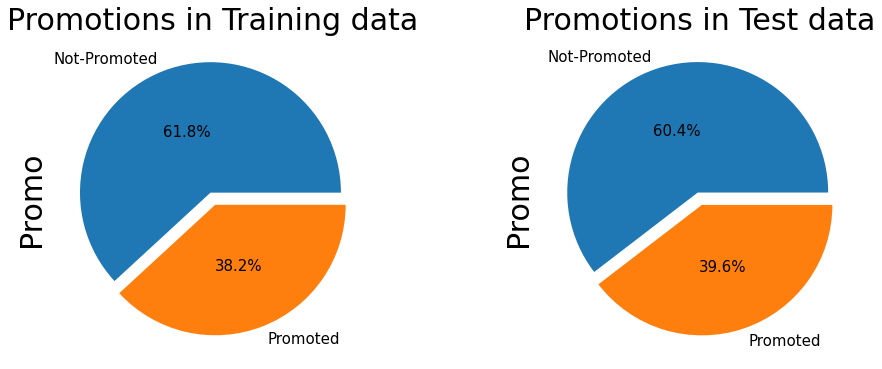

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(16, 6))

lable_font_size = 30
textprops = {"fontsize": 15}
labels = {'Not-Promoted': 0, 'Promoted': 1}
train_promo_count = train_df["Promo"].value_counts().to_frame()

# plt.title("Ratio of overall promotions",
#           fontsize=20, loc='left')
axs[0].pie(data=train_promo_count,
           x='Promo',
           autopct="%.1f%%",
           explode=[0.05]*2,
           labels=labels,
           pctdistance=0.5,
           textprops=textprops,
           )
axs[0].set_label(labels)
axs[0].set_ylabel('Promo', fontsize=lable_font_size)
# axs[0].set_label(labels, fontsize=lable_font_size)
axs[0].set_title('Promotions in Training data', fontsize=lable_font_size)

test_promo_count = test_df["Promo"].value_counts().to_frame()
axs[1].pie(data=test_promo_count,
           x='Promo',
           autopct="%.1f%%",
           explode=[0.05]*2,
           labels=labels,
           pctdistance=0.5,
           textprops=textprops,
           )

axs[1].set_ylabel('Promo', fontsize=lable_font_size)
axs[1].set_title('Promotions in Test data', fontsize=lable_font_size)


print("YES")


##### The distribution of data in the train and test is almost somilar. What is frequently found in the train are also found in the test



<AxesSubplot:title={'center':'sales and customer distribution in training set'}, xlabel='Store'>

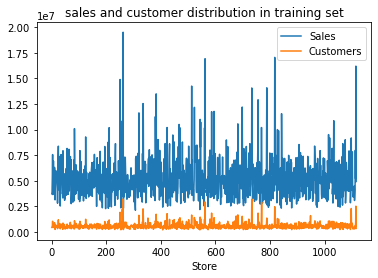

In [ ]:
from turtle import title


train_df.groupby('Store').agg({'Sales':'sum','Customers':'sum'}).plot(title='sales and customer distribution in training set')

## 2. What does sales behavior look like before, during and after holidays?

Let us first look at how the holidays are distributed

StateHoliday

- 0 -> None
- a -> Public Holiday
- b -> Easter
- c -> Christmass



In [ ]:
christmas = train_df.query("StateHoliday=='c'")
christmas_dates = christmas.groupby('Date')['Date'].unique().index
christmas_dates = pd.to_datetime(christmas_dates)
print(
    f"There are {christmas_dates.shape[0]} christmas_dates\n{christmas_dates}")


There are 4 christmas_dates
DatetimeIndex(['2013-12-25', '2013-12-26', '2014-12-25', '2014-12-26'], dtype='datetime64[ns]', name='Date', freq=None)


In [ ]:
grouped_by_date = train_df.groupby(
    'Date')[['Customers', 'Sales', 'SalesPerCustomer']]
grouped_by_date = grouped_by_date.mean()


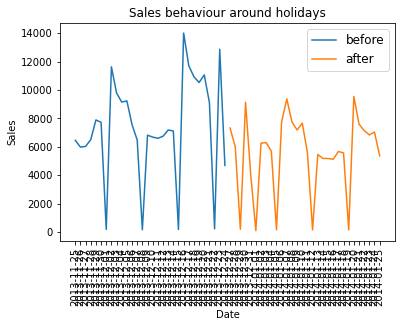

In [ ]:
from turtle import color

before_christmass_idx = grouped_by_date[pd.to_datetime(grouped_by_date.index) < christmas_dates[0]].index[-30:]
after_christmass_idx = grouped_by_date[pd.to_datetime(grouped_by_date.index) > christmas_dates[1]].index[:30]
during_christmass_idx = christmas_dates[0:2]

before_christmass = grouped_by_date[grouped_by_date.index.isin(before_christmass_idx)]
after_christmass = grouped_by_date[grouped_by_date.index.isin(after_christmass_idx)]
during_christmass = grouped_by_date[grouped_by_date.index.isin(during_christmass_idx)]

# sns.set()
sns.lineplot(x=before_christmass.index, y=before_christmass['Sales'])
sns.lineplot(x=after_christmass.index, y=after_christmass['Sales'])
ax = sns.lineplot(x=during_christmass.index, y=during_christmass['Sales'])
ax.set_title("Sales behaviour around holidays")
plt.xticks(rotation=90)
ax.legend(['before', 'after', 'during'], fontsize=12)


## 3. Are there any seasonal (Christmas, Easter etc) purchase behaviours?

In [ ]:
import plotly.express as px
import pandas as pd
seasonal_grouped_by_date = train_df[train_df["Store"]==111].groupby(
    'Date')[['Customers', 'Sales', 'SalesPerCustomer']].sum().reset_index()

In [ ]:

fig = px.line(seasonal_grouped_by_date, x='Date', y='Sales',
              title='Time Series with Range Slider and Selectors')

fig.update_xaxes(
    rangeslider_visible=True,
    rangeselector=dict(
        buttons=list([
            dict(count=1, label="1m", step="month", stepmode="backward"),
            dict(count=6, label="6m", step="month", stepmode="backward"),
            dict(count=1, label="YTD", step="year", stepmode="todate"),
            dict(count=1, label="1y", step="year", stepmode="backward"),
            dict(step="all")
        ])
    )
)
fig.show()



In [ ]:
fig = px.scatter(seasonal_grouped_by_date, x='Date', y='Sales', range_x=['2013-01-01', '2015-07-31'],
                 title="Default Display with Gaps")
fig.show()


In [ ]:

fig = px.scatter(seasonal_grouped_by_date, x='Date', y='Sales', range_x=['2013-01-01', '2015-07-31'],
                 title="Hide Weekend and Holiday Gaps with rangebreaks")
fig.update_xaxes(
    rangebreaks=[
        dict(bounds=["sat", "mon"]),  # hide weekends
        # hide Christmas and New Year's
        dict(values=["2015-12-25", "2016-01-01"])
    ]
)
fig.show()


In [ ]:
# series = train_df[['Date','Sales']]
# series['Date'] = pd.DatetimeIndex(series['Date'])
# series = series.set_index('Date')
# X = series.values
# diff = list()
# days_in_year = 365
# for i in range(days_in_year, len(X)):
# 	value = X[i] - X[i - days_in_year]
# 	diff.append(value)
# pyplot.plot(diff)
# pyplot.show()


/var/folders/6b/0t1qb1d92f72c46kvp35pwfc0000gn/T/ipykernel_2446/847241077.py:6: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



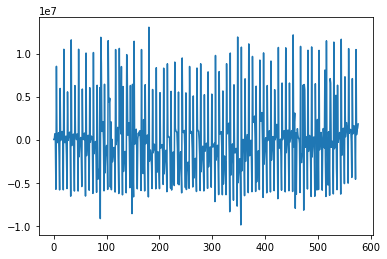

In [ ]:
grouped_by_date = train_df.groupby(
    'Date')[['Customers', 'Sales', 'SalesPerCustomer']].sum().reset_index()

series = grouped_by_date[['Date','Sales']]

series['Date'] = pd.DatetimeIndex(series['Date'])
series = series.set_index('Date')
X = series.values
diff = list()
days_in_year = 365
for i in range(days_in_year, len(X)):
	value = X[i] - X[i - days_in_year]
	diff.append(value)
pyplot.plot(diff)
pyplot.show()



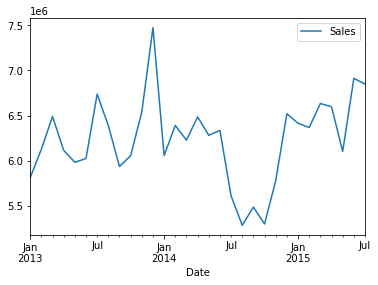

In [ ]:
resample = series.resample('M')
monthly_mean = resample.mean()
monthly_mean.plot()
pyplot.show()


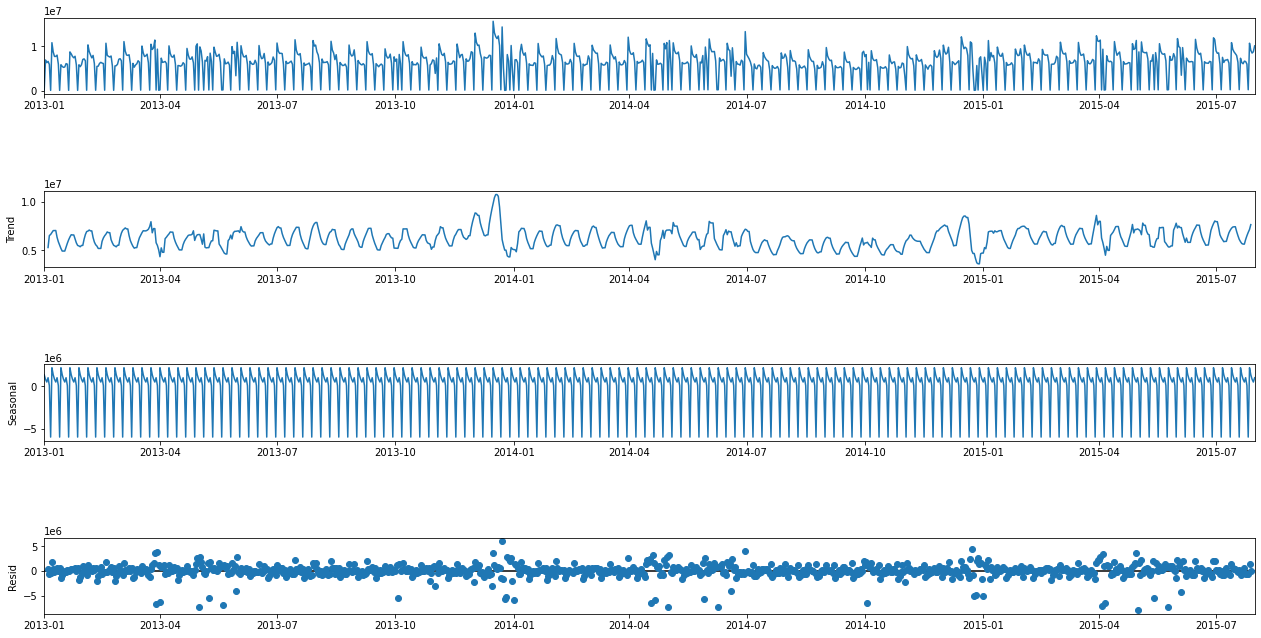

In [ ]:
decomposition = seasonal_decompose(series, model='additive')
fig = decomposition.plot()
fig.set_size_inches(20, 10)
plt.show()


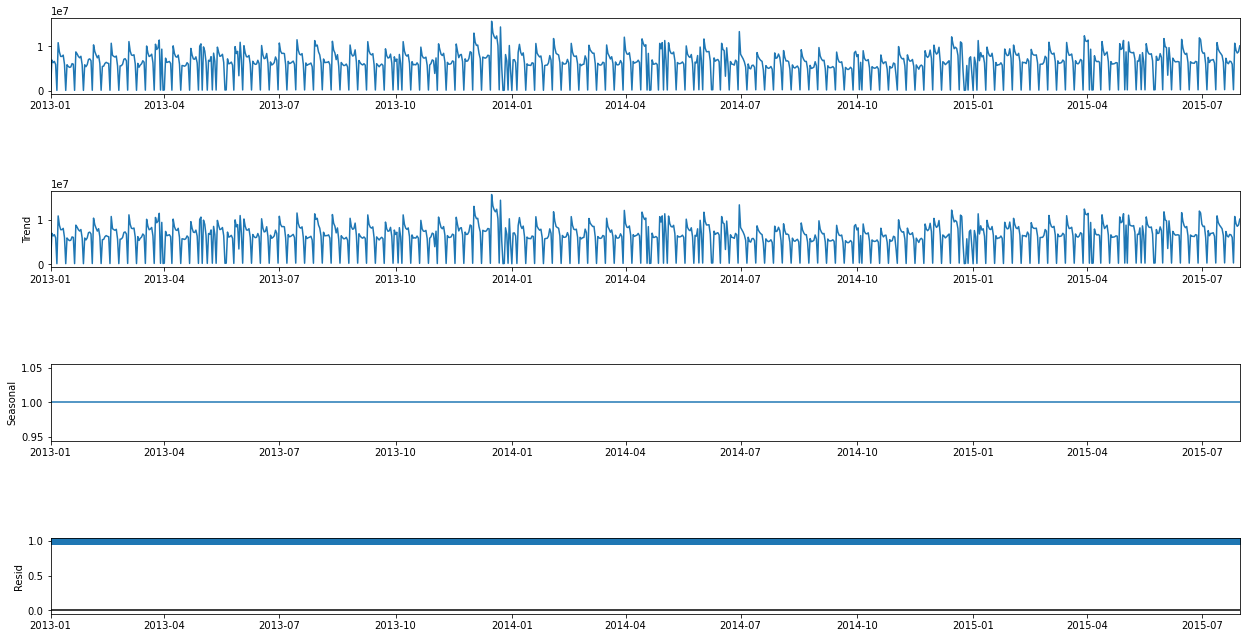

In [ ]:
# series = [i**2.0 for i in range(1, 100)]
decomposition = seasonal_decompose(series, model='multiplicative', period=1)
fig = decomposition.plot()
fig.set_size_inches(20, 10)
plt.show()


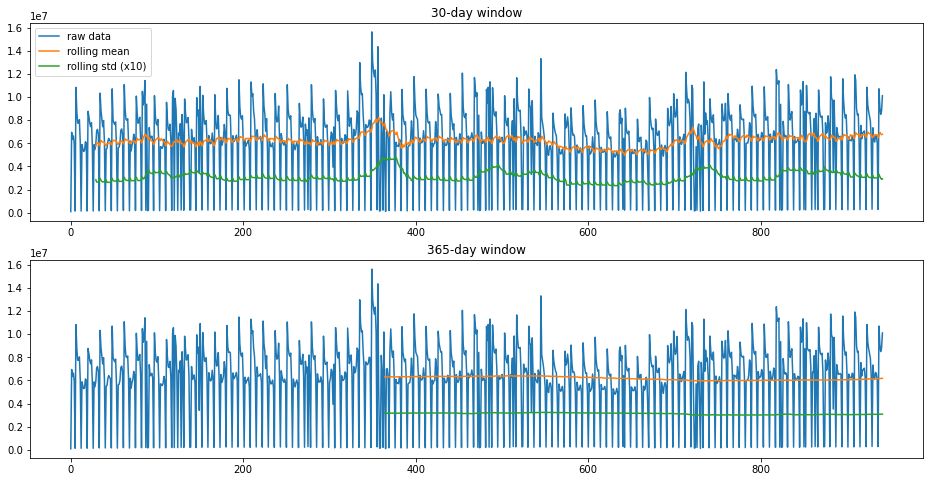

In [ ]:
def analyze_stationarity(timeseries, title):
    fig, ax = plt.subplots(2, 1, figsize=(16, 8))

    rolmean = pd.Series(timeseries).rolling(window=30).mean()
    rolstd = pd.Series(timeseries).rolling(window=30).std()
    ax[0].plot(timeseries, label=title)
    ax[0].plot(rolmean, label='rolling mean')
    ax[0].plot(rolstd, label='rolling std (x10)')
    ax[0].set_title('30-day window')
    ax[0].legend()

    rolmean = pd.Series(timeseries).rolling(window=365).mean()
    rolstd = pd.Series(timeseries).rolling(window=365).std()
    ax[1].plot(timeseries, label=title)
    ax[1].plot(rolmean, label='rolling mean')
    ax[1].plot(rolstd, label='rolling std (x10)')
    ax[1].set_title('365-day window')



pd.options.display.float_format = '{:.8f}'.format
analyze_stationarity(np.array(series.values).reshape(942,), 'raw data')
ax.legend()


From the first figure we got using rolling average with window of 30-days we observe seasonality to some extent. from the second image wich is obtained by rolling mean with 365-day window we see there is no trneds in the sereies.

In [ ]:
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.tsa.api import ExponentialSmoothing
%matplotlib inline


In [ ]:
def ADF_test(timeseries):
    print("Results of Dickey-Fuller Test:")
    dftest = adfuller(timeseries, autolag="AIC")
    dfoutput = pd.Series(
        dftest[0:4],
        index=[
            "Test Statistic",
            "p-value",
            "Lags Used",
            "Number of Observations Used",
        ],
    )
    for key, value in dftest[4].items():
        dfoutput["Critical Value (%s)" % key] = value
    print(dfoutput)


ADF_test(np.array(series.values).reshape(942,))


Results of Dickey-Fuller Test:
Test Statistic                 -4.76161452
p-value                         0.00006437
Lags Used                      20.00000000
Number of Observations Used   921.00000000
Critical Value (1%)            -3.43747011
Critical Value (5%)            -2.86468326
Critical Value (10%)           -2.56844367
dtype: float64


In [ ]:
def KPSS_test(timeseries):
    print("Results of KPSS Test:")
    kpsstest = kpss(timeseries, regression="c", nlags="auto")
    kpss_output = pd.Series(
        kpsstest[0:3], index=["Test Statistic", "p-value", "Lags Used"]
    )
    for key, value in kpsstest[3].items():
        kpss_output["Critical Value (%s)" % key] = value
    print(kpss_output)


KPSS_test(np.array(series.values).reshape(942,))


Results of KPSS Test:


/Users/user/miniforge3/envs/10A/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:2022: InterpolationWarning:

The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.




Test Statistic           0.20507441
p-value                  0.10000000
Lags Used               10.00000000
Critical Value (10%)     0.34700000
Critical Value (5%)      0.46300000
Critical Value (2.5%)    0.57400000
Critical Value (1%)      0.73900000
dtype: float64


- The result of the ADF test (p-value below 0.05) suggests that the null hypothesis of the presence of a unit root can be rejected at a 95% confidence level. Hence, if the p-value is below 0.05, the time-series is stationary.
- The result of the KPSS test (p-value above 0.05) suggests that the null hypothesis of the absence of a unit root presence of unit root cannot be rejected at a 95% confidence level. Hence, if the p-value is below 0.05, the time-series is not stationary.

- Interestingly, the statistical results revealed an effect of the stationarity of the time-series. However, the null hypothesis for both tests is the opposite. While the ADF test indicates that the time-series is stationary (p-value > 0.05), the KPSS test reveals that it is not stationary (p-value > 0.05). This dataset was created with a slight trend, so results pinpoint that the KPSS test is more accurate for analyzing this dataset.

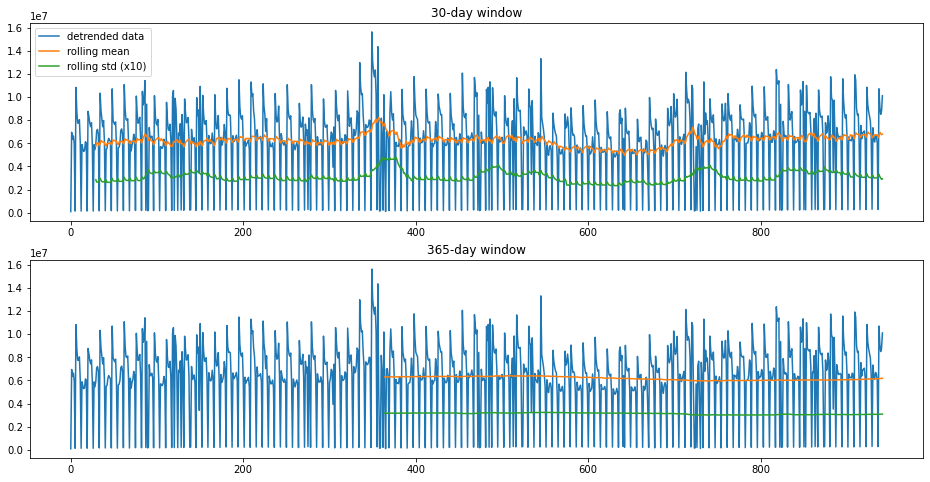

In [ ]:
df = pd.DataFrame(np.array(series.values).reshape(942,))
df_detrend = (df - df.rolling(window=365).mean()) / df.rolling(window=365).std()

analyze_stationarity(np.array(series.values).reshape(942,), 'detrended data')
# ADF_test(df_detrend)


Results of Dickey-Fuller Test:
Test Statistic                 -2.84375691
p-value                         0.05229012
Lags Used                      18.00000000
Number of Observations Used   558.00000000
Critical Value (1%)            -3.44212354
Critical Value (5%)            -2.86673358
Critical Value (10%)           -2.56953601
dtype: float64


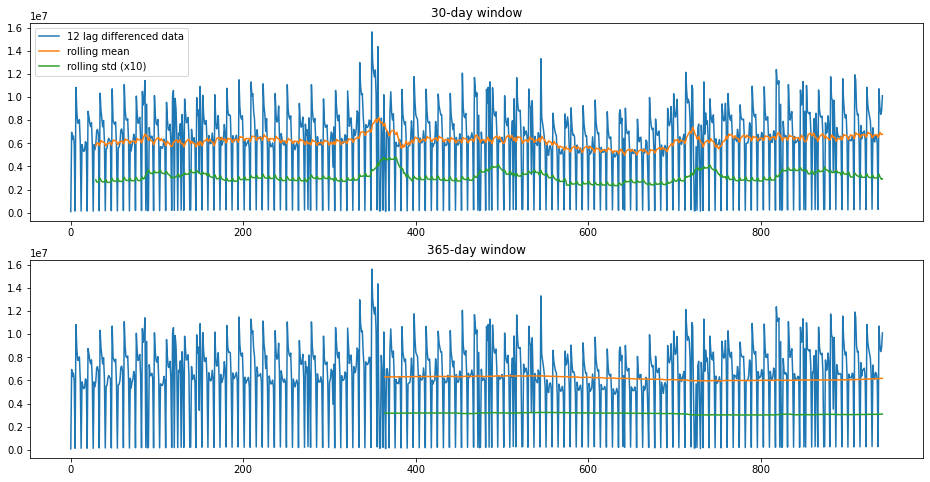

In [ ]:
df_365lag = df - df.shift(365)

analyze_stationarity(np.array(series.values).reshape(
    942,), '12 lag differenced data')
ADF_test(df_365lag.dropna())


## 4. Correlation between sales and number of customers

In [ ]:
df_correlation = train_df[['DayOfWeek', 'Sales', 'Customers', 'Open', 'Promo',
                           'Promo2', 'SalesPerCustomer','StateHoliday', 'Assortment', 
                           'StoreType','PromoInterval', 'CompetitionDistance']]

df_correlation = df_correlation.drop('Open', axis=1)
upper_triangle = np.zeros_like(df_correlation.corr(), dtype=bool)
upper_triangle[np.triu_indices_from(upper_triangle)] = True
f, ax = plt.subplots(figsize=(15, 10))
sns.heatmap(df_correlation.corr(),
            ax=ax,
            annot=True,
            mask=upper_triangle,
            fmt='.2f',
            linewidths=0.5,
            cmap=sns.diverging_palette(15, 500, as_cmap=True))
ax.set_title(
    "Correlation map of selected sales and store features", fontsize=20)


KeyError: "['Month', 'Year'] not in index"

## 5. How does promo affect sales? Are the promos attracting more customers? How does it affect already existing customers?

In [ ]:
grouped_by_promo = train_df.query("Sales>0 & Customers>0 & Open==1").groupby(
    'Promo')['Sales'].describe().transpose()
grouped_by_promo


Promo,0,1
count,467463.00000000,376875.00000000
mean,5929.82618303,8228.73973068
std,2629.26922941,3175.25359395
min,46.00000000,133.00000000
25%,4242.00000000,6070.00000000
50%,5459.00000000,7650.00000000
75%,7004.00000000,9686.00000000
max,41551.00000000,38722.00000000


Text(0.5, 1.0, 'Average Sales vs Promo')

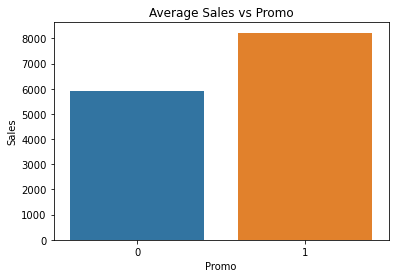

In [ ]:
mean_sale_promo = train_df.query("Sales>0 & Customers>0 & Open==1").groupby(
    'Promo')['Sales'].mean().to_frame()
ax = sns.barplot(data=mean_sale_promo, x=mean_sale_promo.index, y='Sales')
ax.set_title("Average Sales vs Promo")


,SalesPerCustomer
Promo,
0,4179646.37649410
1,3836195.89279895


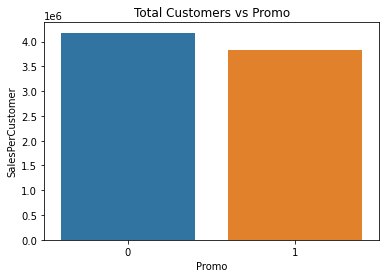

In [ ]:
total_customers_promo = train_df.query("Sales>0 & Customers>0 & Open==1").groupby(
    'Promo')['SalesPerCustomer'].sum().to_frame()
ax = sns.barplot(data=total_customers_promo,
                 x=total_customers_promo.index, y='SalesPerCustomer')
ax.set_title("Total Customers vs Promo")
total_customers_promo


- The promo increases by increasing the amount of sales per customer.
- It makes some people to stay away from the store. 
- It is not attracting more customers, instead it is making some customers to spend more. 

## 6. Could the promos be deployed in more effective ways? Which stores should promos be deployed in?

In [ ]:
grouped_by_store = train_df.groupby('Store')[['Sales', 'Customers']].sum()
grouped_by_store.head()


,Sales,Customers
Store,,
1,3716854,440523
2,3883858,457855
3,5408261,584310
4,7556507,1036254
5,3642818,418588


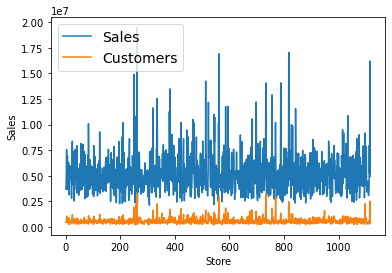

In [ ]:
sns.lineplot(data=grouped_by_store, x=grouped_by_store.index, y='Sales')
sns.lineplot(data=grouped_by_store, x=grouped_by_store.index, y='Customers')
plt.legend(['Sales', 'Customers'], fontsize=14)


## 7. Trends of customer behavior during store open and closing times


## 8. Which stores are opened on all weekdays? How does that affect their sales on weekends?

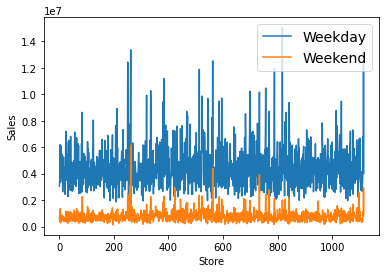

In [ ]:
# stores_open_on_weekdays = train_df.query("DayOfWeek!=7 & DayOfWeek!=6 & Open==1")['Store'].unique()
stores_open_on_weekdays = train_df.query("Open==1")['Store'].unique()
sales_stores_open_on_weekdays = train_df[(train_df["Store"].isin(
    stores_open_on_weekdays) & train_df['Open'] == 1 & ~train_df['DayOfWeek'].isin([6, 7]))].groupby('Store')['Sales'].sum()
sns.lineplot(data=sales_stores_open_on_weekdays)
sales_stores_open_on_weekends = train_df[(train_df["Store"].isin(
    stores_open_on_weekdays) & train_df['Open'] == 1 & train_df['DayOfWeek'].isin([6, 7]))].groupby('Store')['Sales'].sum()
sns.lineplot(data=sales_stores_open_on_weekends)
plt.legend(['Weekday', 'Weekend'], fontsize=14, loc='upper right')


In [ ]:
for i,v in sales_stores_open_on_weekends.items():
    if i == 817  :# sales_stores_open_on_weekends.max():
        print(i,v)


817 1990511


In [ ]:
6162493 + 13354349

19516842

In [ ]:
for i, v in sales_stores_open_on_weekdays.items():
    if i == 262 : # sales_stores_open_on_weekdays.max():
        print(i, v)


262 13354349


In [ ]:
1990511 + 15067356


17057867

Sales on Weekends are significanly lower than on weekdays. But, I can't be certain that this has to do with the fact that they were also open during the week days. Most stores are closed on weekends, so sales are generally down on weekends.

## 9. How does assortment type affects sales?

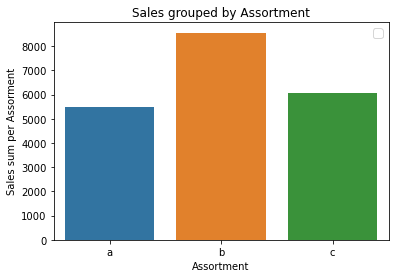

In [ ]:
grouped_by_year_assortment = train_df.groupby(
    ['Assortment'])['Sales'].mean().to_frame()
ax = sns.barplot(x=grouped_by_year_assortment.index,
                 y=grouped_by_year_assortment['Sales'].values,
                 # xlabel="Assortment",
                 # ylabel='Sales sum per Assorment',
                 # title='Sales grouped by Assortment'
                 )
ax.set_ylabel('Sales sum per Assorment')
ax.set_title('Sales grouped by Assortment')
plt.legend(fontsize=12)


Assortment type 'b' Has the largest mean sales followed by 'c' and 'a'

## 10. How does the distance to the next competitor affect sales? What if the store and its competitors all happen to be in city centres, does the distance matter in that case?

Text(0.5, 0, 'CompetitionDistance')

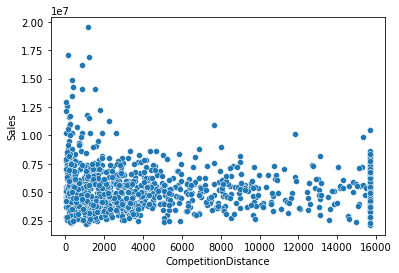

In [ ]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
# comp_dist = scaler.fit_transform(
comp_dist = train_df.groupby('Store')[['CompetitionDistance']].min()  # )[:, 0]
# store_sales = scaler.fit_transform(
store_sales = train_df.groupby('Store')[['Sales']].sum()  # )[:, 0]

ax = sns.scatterplot(x=comp_dist.values[:, 0], y=store_sales.values[:, 0])
ax.set_ylabel('Sales')
ax.set_xlabel('CompetitionDistance')


- The increase in competition distance  do not increase sales. 
- Most of the store has competition but do not show difference in their sales compared to those with no less competition
- May be having more competition indicates the demand increase in the area. There may be anotheer factor

## 11. How does the opening or reopening of new competitors affect stores? Check for stores with NA as competitor distance but later on has values for competitor distance


In [ ]:
grouped_by_date = train_df.dropna()
grouped_by_date['CompetitionOpenDate'] = pd.to_datetime(grouped_by_date['CompetitionOpenSinceYear'].astype(
    'int').astype('str')+'-'+grouped_by_date['CompetitionOpenSinceMonth'].astype('int').astype('str'))
first_competition_date = grouped_by_date['CompetitionOpenDate'].iloc[0]
first_competition_date


/var/folders/6b/0t1qb1d92f72c46kvp35pwfc0000gn/T/ipykernel_24614/2014204532.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Timestamp('2007-11-01 00:00:00')